# ABS tutorial 04

## partial-sky ABS pipeline (with noise)

To validate the ABS method we have simulated a few foregrounds maps including dust and synchrotron at 30, 95, 150 and 353 GHz, using PySM package. CAMB is utilized to predict the CMB power spectra with respect to the Planck best fit 2018 results, from which random realizations of CMB anisotropies are obtained. For the tensor-to-scalar ratio, we set it as 0.05 for the generation of CMB maps. White noise maps are generated according to the Planck level.

Measurement uncertainties are prepared as white noise.

In [1]:
import numpy as np
import healpy as hp
import matplotlib
import abspy as ap
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### read in maps

In [2]:
NSIDE = 128

map30 = hp.read_map('./data/TQU_30GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)
map95 = hp.read_map('./data/TQU_95GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)
map150 = hp.read_map('./data/TQU_150GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)
map353 = hp.read_map('./data/TQU_353GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)
mapcmb = hp.read_map('./data/TQU_CMB_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)

NSCAL = 1.
vmap30 = hp.read_map('./data/TQU_var_30GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)*NSCAL
vmap95 = hp.read_map('./data/TQU_var_95GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)*NSCAL
vmap150 = hp.read_map('./data/TQU_var_150GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)*NSCAL
vmap353 = hp.read_map('./data/TQU_var_353GHz_r7.fits',field=[0,1,2],dtype=np.float64,verbose=0)*NSCAL

print (map95.shape, map95.dtype)

(3, 196608) float64


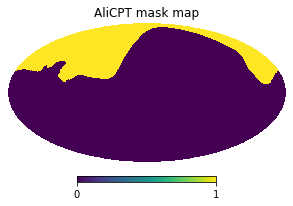

In [3]:
mask = hp.read_map('./data/ali_mask_r7.fits',dtype=bool,verbose=False)

fig = matplotlib.pyplot.figure(figsize=(5,5))
gs = matplotlib.gridspec.GridSpec(5, 5)
fig.add_subplot(gs[0:5, 0:5])
hp.mollview(mask,title='AliCPT mask map',hold=True)

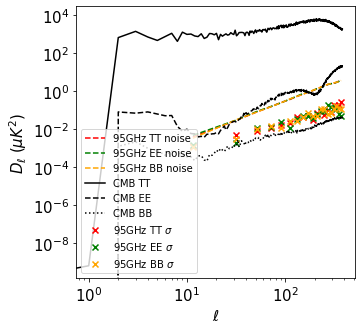

In [4]:
RESAMP = 5  # size of resampling
BINNING = 20
NPIX = 12*NSIDE**2
est = ap.pstimator(nside=NSIDE, mask=mask.reshape(1,-1), aposcale=5.0, psbin=BINNING)
auto_cmb = est.auto_t(mapcmb[0].reshape(1,-1))
Nell = len(auto_cmb[0])

n95 = np.zeros((3,NPIX,RESAMP))

for i in range(NPIX):
    for j in range(3):
        if mask[i]:
            n95[j,i,:] = np.random.normal(0,np.sqrt(vmap95[j,i]),RESAMP)
            
auto_n95 = np.zeros((3,Nell))
sigma_n95 = np.zeros((3,Nell))
for i in range(RESAMP):
    _tmp = est.auto_t(n95[0,:,i].reshape(1,-1))
    auto_n95[0] += _tmp[1]
    sigma_n95[0] += np.array(_tmp[1])*np.array(_tmp[1])
    _tmp = est.auto_eb(n95[1:,:,i].reshape(2,-1))
    auto_n95[1] += _tmp[1]
    auto_n95[2] += _tmp[2]
    sigma_n95[1] += np.array(_tmp[1])*np.array(_tmp[1])
    sigma_n95[2] += np.array(_tmp[2])*np.array(_tmp[2])
auto_n95 /= RESAMP
sigma_n95 = np.sqrt(sigma_n95/RESAMP - auto_n95**2)


fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

ax.plot(auto_cmb[0],auto_n95[0],
        color='red',linestyle='--',label='95GHz TT noise')
ax.scatter(auto_cmb[0],sigma_n95[0],
          color='red',marker='x',label='95GHz TT $\sigma$')

ax.plot(auto_cmb[0],auto_n95[1],
        color='green',linestyle='--',label='95GHz EE noise')
ax.scatter(auto_cmb[0],sigma_n95[1],
          color='green',marker='x',label='95GHz EE $\sigma$')

ax.plot(auto_cmb[0],auto_n95[2],
        color='orange',linestyle='--',label='95GHz BB noise')
ax.scatter(auto_cmb[0],sigma_n95[2],
          color='orange',marker='x',label='95GHz BB $\sigma$')

cmb_cl = hp.anafast(mapcmb)
ell = np.arange(len(cmb_cl[0]))
ax.plot(cmb_cl[0]*0.5*ell*(ell+1)/np.pi,
        color='black',linestyle='-',label=r'CMB TT')
ax.plot(cmb_cl[1]*0.5*ell*(ell+1)/np.pi,
        color='black',linestyle='--',label=r'CMB EE')
ax.plot(cmb_cl[2]*0.5*ell*(ell+1)/np.pi,
        color='black',linestyle=':',label=r'CMB BB')

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
#ax.set_ylim((1.e-7,1.e7))

- TT

In [5]:
fullmap = np.zeros((4,1,12*NSIDE**2))
fullmap[0] = map30[0]
fullmap[1] = map95[0]
fullmap[2] = map150[0]
fullmap[3] = map353[0]

fullvar = np.zeros((4,1,12*NSIDE**2))
fullvar[0] = vmap30[0]
fullvar[1] = vmap95[0]
fullvar[2] = vmap150[0]
fullvar[3] = vmap353[0]

pipeline1 = ap.abspipe(fullmap,nfreq=4,nmap=1,nside=NSIDE,mask=mask.reshape(1,-1),variance=fullvar,
                       fwhms=[1.e-3,1.e-3,1.e-3,1.e-3])
pipeline1.nsamp = 5
rslt_t = pipeline1(psbin=20,absbin=8,shift=10.,threshold=1.)

- EE and BB

In [6]:
fullmap = np.zeros((4,2,12*NSIDE**2))
fullmap[0] = map30[1:]
fullmap[1] = map95[1:]
fullmap[2] = map150[1:]
fullmap[3] = map353[1:]

fullvar = np.zeros((4,2,12*NSIDE**2))
fullvar[0] = vmap30[1:]
fullvar[1] = vmap95[1:]
fullvar[2] = vmap150[1:]
fullvar[3] = vmap353[1:]

pipeline2 = ap.abspipe(fullmap,nfreq=4,nmap=2,nside=NSIDE,mask=mask.reshape(1,-1),variance=fullvar,
                      fwhms=[1.e-3,1.e-3,1.e-3,1.e-3])
pipeline2.nsamp = 5
rslt_eb = pipeline2(psbin=20,absbin=8,shift=10.,threshold=0.2)

visualize

(1, 384)

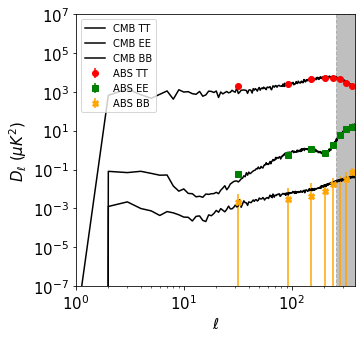

In [7]:
fig,ax = matplotlib.pyplot.subplots(figsize=(5,5))

cmb_cl = hp.anafast(mapcmb)
ell = np.arange(len(cmb_cl[0]))
ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[0],
        color='black',linestyle='-',label=r'CMB TT')
ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[1],
        color='black',linestyle='-',label=r'CMB EE')
ax.plot((0.5/np.pi)*ell*(ell+1)*cmb_cl[2],
        color='black',linestyle='-',label=r'CMB BB')
    
ax.errorbar(rslt_t[0],rslt_t[1],yerr=rslt_t[2],
            color='red',fmt='o',label=r'ABS TT')
ax.errorbar(rslt_eb[0],rslt_eb[1],yerr=rslt_eb[2],
            color='green',fmt='s',label=r'ABS EE')
ax.errorbar(rslt_eb[0],rslt_eb[3],yerr=rslt_eb[4],
            color='orange',fmt='X',label=r'ABS BB')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'$\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((1,3*NSIDE))

end